## Imports

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeFeatures
import pandas as pd
import json


from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score,silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import networkx as nx
from node2vec import Node2Vec

import matplotlib.pyplot as plt
import numpy as np


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Φόρτωση και προετοιμασία του αρχείου

In [ ]:
# Διαβάζουμε το αρχείο που περιέχει τις ακμές του γραφήματος
edges = pd.read_csv("facebook_large/musae_facebook_edges.csv")
# Μετονομάζουμε τις στήλες για ευκολότερη αναφορά
edges.columns = ['source', 'target']

# Διαβάζουμε τα χαρακτηριστικά των κόμβων από το αρχείο JSON
with open("facebook_large/musae_facebook_features.json") as f:
    features_dict = json.load(f)

# Διαβάζουμε τις ετικέτες στόχου από το αρχείο CSV
targets = pd.read_csv("facebook_large/musae_facebook_target.csv")

# Ετοιμάζουμε τα χαρακτηριστικά για τους κόμβους
max_len = max(len(v) for v in features_dict.values())  # Βρίσκουμε το μέγιστο μήκος χαρακτηριστικών
node_features = []  # Λίστα για τα χαρακτηριστικά των κόμβων
node_idx_map = {}  # Χάρτης για τη σύνδεση του node_id με τον δείκτη του κόμβου

# Γεμίζουμε τα χαρακτηριστικά για κάθε κόμβο
for idx, (node_id, feature_vector) in enumerate(features_dict.items()):
    node_idx_map[int(node_id)] = idx  # Αντιστοιχία κόμβου με δείκτη
    # Αν το χαρακτηριστικό vector είναι μικρότερο από το μέγιστο μήκος, το γεμίζουμε με μηδενικά
    padded = feature_vector + [0.0] * (max_len - len(feature_vector))
    node_features.append(padded)

# Μετατρέπουμε τα χαρακτηριστικά των κόμβων σε tensor
x = torch.tensor(node_features, dtype=torch.float)

# Δημιουργούμε το edge_index, το οποίο αναπαριστά τις ακμές του γραφήματος
edge_index = torch.tensor([
    [node_idx_map[src] for src in edges['source']],  # Πηγαίνουμε από τον κόμβο src
    [node_idx_map[tgt] for tgt in edges['target']]   # Στον κόμβο tgt
], dtype=torch.long)

# Δημιουργούμε το αντικείμενο Data από το PyTorch Geometric για να αποθηκεύσουμε τα δεδομένα
data = Data(x=x, edge_index=edge_index)

# Κανονικοποιούμε τα χαρακτηριστικά των κόμβων
data = NormalizeFeatures()(data)


## Ανάλυση γράφου

This webgraph is a page-page graph of verified Facebook sites. Nodes represent official Facebook pages while the links are mutual likes between sites. Node features are extracted from the site descriptions that the page owners created to summarize the purpose of the site. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies

### Οπτικοποίηση του γράφου

In [11]:
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())

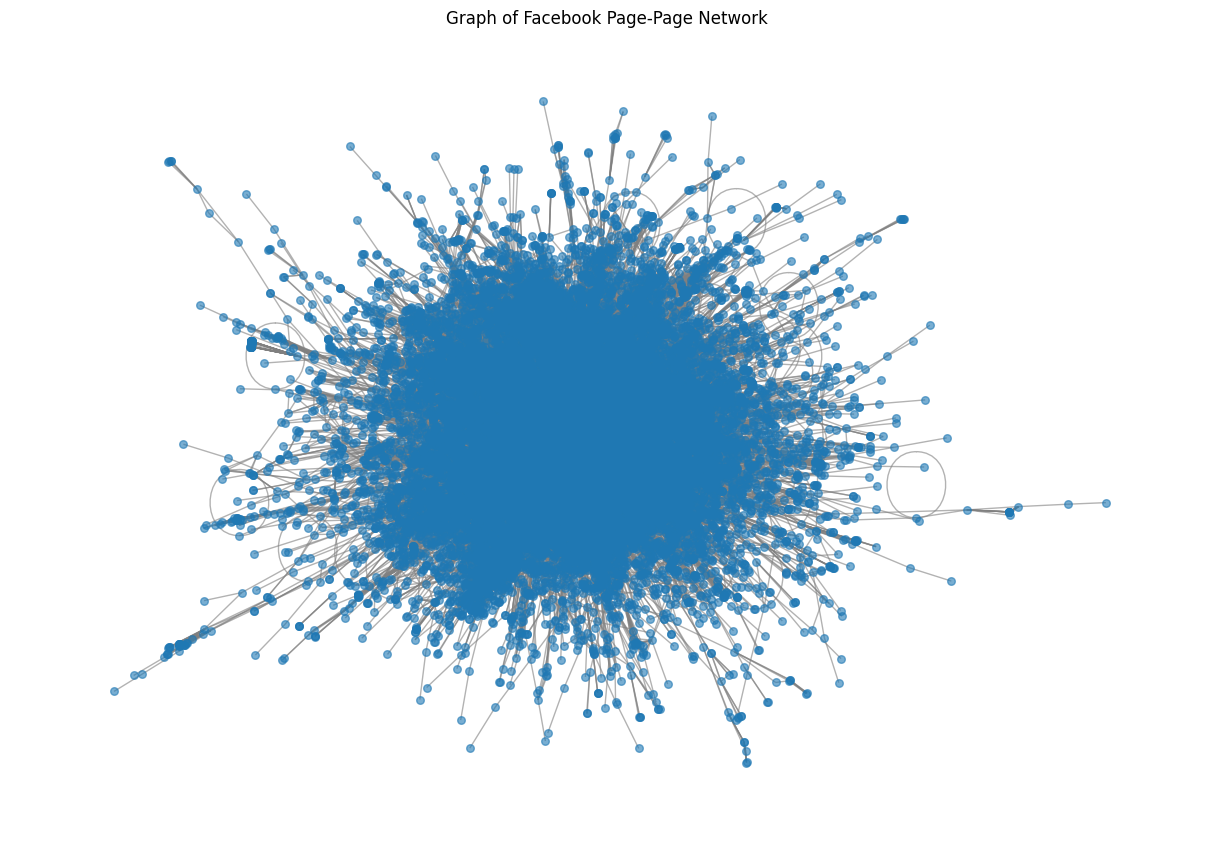

In [ ]:
plt.figure(figsize=(12, 8))
nx.draw_spring(G, node_size=30, edge_color='gray', alpha=0.6)
plt.title("Graph of Facebook Page-Page Network ")
plt.show()

### Βασικά Χαρακτηριστικά του γράφου

In [12]:
true_labels = targets['page_type'].values
print("Categories")
for i,label in enumerate(set(true_labels)):
    print(f"{i+1}:{label}")

Categories
1:government
2:company
3:tvshow
4:politician


In [6]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
flag=nx.is_connected(G)
print("Is the graph connected?", flag)


Number of nodes: 22470
Number of edges: 171002
Is the graph connected? True


In [7]:
degrees=dict(G.degree())
print("Average degree:", sum(degrees.values()) / len(degrees))

Average degree: 15.220471740097908


In [20]:
density = nx.density(G)
print(f"Graph Density: {density}")

Graph Density: 0.000677398715568023


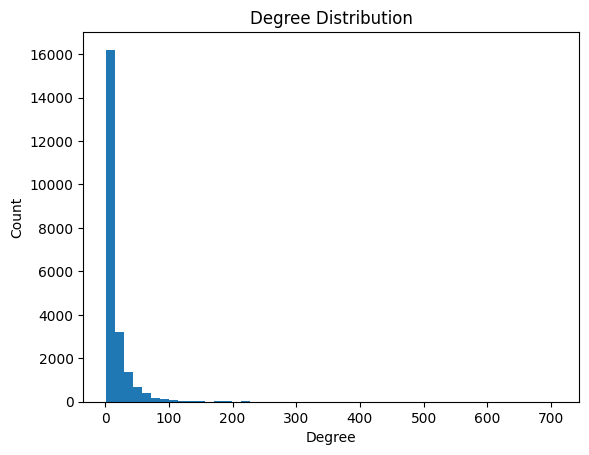

In [8]:
plt.hist(degrees.values(),bins=50)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [9]:
print("Average shortest path length:", nx.average_shortest_path_length(G))
print("Diameter (longest shortest path):", nx.diameter(G))
print("Clustering coefficient:", nx.average_clustering(G))

Average shortest path length: 4.973703570580348
Diameter (longest shortest path): 15
Clustering coefficient: 0.3597383824426949


Το μέσο μήκος της συντομότερης διαδρομής είναι περίπου 4.97, κάτι που υποδηλώνει ότι οποιοιδήποτε δύο κόμβοι μπορούν να συνδεθούν μέσω σχετικά λίγων βημάτων.Δηλαδή το δίκτυο είναι καλα συνδεδεμενο.Η διάμετρος του γραφήματος είναι 15, γεγονός που φανερώνει την ύπαρξη κάποιων απομακρυσμένων περιοχών μέσα στο δίκτυο.Ο συντελεστής συσσωμάτωσης (clustering coefficient) είναι 0.36, κάτι που σημαίνει ότι οι γείτονες ενός κόμβου έχουν σε σημαντικό βαθμό μεταξύ τους συνδέσεις, αν και όχι πλήρως.

## Δημιουργία αναπαραστάσεων κόμβων με χρήση Node2vec

### Εκπαίδευση του μοντέλου

In [15]:
node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4, p=1, q=1)

model = node2vec.fit(window=10, min_count=1)


Computing transition probabilities:   0%|          | 0/22470 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 22470/22470 [01:19<00:00, 280.92it/s] 


### Πίνακας με τα embeddings

In [17]:
nodes=list(G.nodes())
embeddings=[model.wv[str(node)] for node in nodes]

embeddingsN2v=pd.DataFrame(embeddings,index=nodes)

In [12]:
embeddingsN2v.shape

(22470, 128)

## Δημιουργία αναπαραστάσεων κόμβων με χρήση Graph Sage


### Ορισμός του GraphSage Μοντέλου

In [ ]:
class GraphSAGE(nn.Module):
    # Αρχικοποιητής της κλάσης, ο οποίος παίρνει τα εισαγωγικά και εξαγωγικά κανάλια
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Δημιουργία του πρώτου στρώματος SAGEConv με είσοδο in_channels και έξοδο hidden_channels
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        
        # Δημιουργία του δεύτερου στρώματος SAGEConv με είσοδο hidden_channels και έξοδο out_channels
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    # Μέθοδος forward για την προώθηση των δεδομένων μέσα από το μοντέλο
    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Λαμβάνουμε τα χαρακτηριστικά (x) και τις ακμές (edge_index) από το data
        
        # Εφαρμόζουμε το πρώτο στρώμα SAGEConv στο x και edge_index
        x = self.conv1(x, edge_index)
        
        # Εφαρμόζουμε τη συνάρτηση ενεργοποίησης ReLU
        x = F.relu(x)
        
        # Εφαρμόζουμε το δεύτερο στρώμα SAGEConv
        x = self.conv2(x, edge_index)
        
        # Επιστρέφουμε τα αποτελέσματα από το δεύτερο στρώμα
        return x

### Loss Function

Στο GraphSAGE με μη επιβλεπόμενο loss, το μοντέλο μαθαίνει ώστε οι γειτονικοί κόμβοι στον γράφο να έχουν παρόμοια embeddings, ενώ τυχαίοι, μη γειτονικοί κόμβοι να έχουν όσο το δυνατόν διαφορετικά embeddings. Αυτό γίνεται μέσω ενός loss που ενισχύει τις θετικές σχέσεις και αποθαρρύνει τις αρνητικές, χρησιμοποιώντας τεχνικές negative sampling.

In [ ]:
def graphsage_unsupervised_loss(embeddings, edge_index, num_nodes, num_neg_samples=5):
    src, tgt = edge_index  
    # θετικά δείγματα
    pos_score = (embeddings[src] * embeddings[tgt]).sum(dim=-1)
    
    # αρνητικά δείγματα: για κάθε src κόμβο, τυχαία neg_targets
    neg_targets = torch.randint(0, num_nodes, (src.size(0), num_neg_samples), device=embeddings.device)
    
    # src επαναλαμβάνεται για κάθε neg_target
    src_repeat = src.unsqueeze(1).repeat(1, num_neg_samples)
    
    neg_score = (embeddings[src_repeat] * embeddings[neg_targets]).sum(dim=-1)

    # Positive loss
    pos_loss = -F.logsigmoid(pos_score).mean()

    # Negative loss
    neg_loss = -F.logsigmoid(-neg_score).mean()

    loss = pos_loss + neg_loss
    return loss


### Un-supervised Εκπαίδευση

In [6]:
def train(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = graphsage_unsupervised_loss(out, data.edge_index, data.num_nodes, num_neg_samples=5)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch:02d}, Loss: {loss.item():.4f}")

In [7]:
model = GraphSAGE(in_channels=data.num_features, hidden_channels=64, out_channels=128)
train(model,data)

Epoch 00, Loss: 1.6622
Epoch 10, Loss: 1.3993
Epoch 20, Loss: 1.3767
Epoch 30, Loss: 1.3626
Epoch 40, Loss: 1.3426
Epoch 50, Loss: 1.3090
Epoch 60, Loss: 1.2779
Epoch 70, Loss: 1.2727
Epoch 80, Loss: 1.2656
Epoch 90, Loss: 1.2607


### Εξαγωγή των embeddings

In [8]:
model.eval()
embeddingsGCN = model(data).detach().cpu().numpy()

In [9]:
embeddingsGCN.shape

(22470, 128)

## Clustering

In [13]:
le=LabelEncoder()
labels_encoded=le.fit_transform(true_labels)

def scores(name, true_labels, predicted_labels, embeddings):
    print(f"For {name} method the metrics are:\n")
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    sil_score = silhouette_score(embeddings, predicted_labels)

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Silhouette Score: {sil_score:.4f}",)
    print('\n')

### Kmeans

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)

labelsN2V=kmeans.fit_predict(embeddingsN2v)
labelsGSM=kmeans.fit_predict(embeddingsGCN)


scores("Node2Vec", labels_encoded, labelsN2V, embeddingsN2v)
scores("GCN", labels_encoded, labelsGSM, embeddingsGCN)

For Node2Vec method the metrics are:

Adjusted Rand Index (ARI): -0.0000
Normalized Mutual Information (NMI): 0.0001
Silhouette Score: 0.0283


For GCN method the metrics are:

Adjusted Rand Index (ARI): 0.0002
Normalized Mutual Information (NMI): 0.0002
Silhouette Score: 0.4933




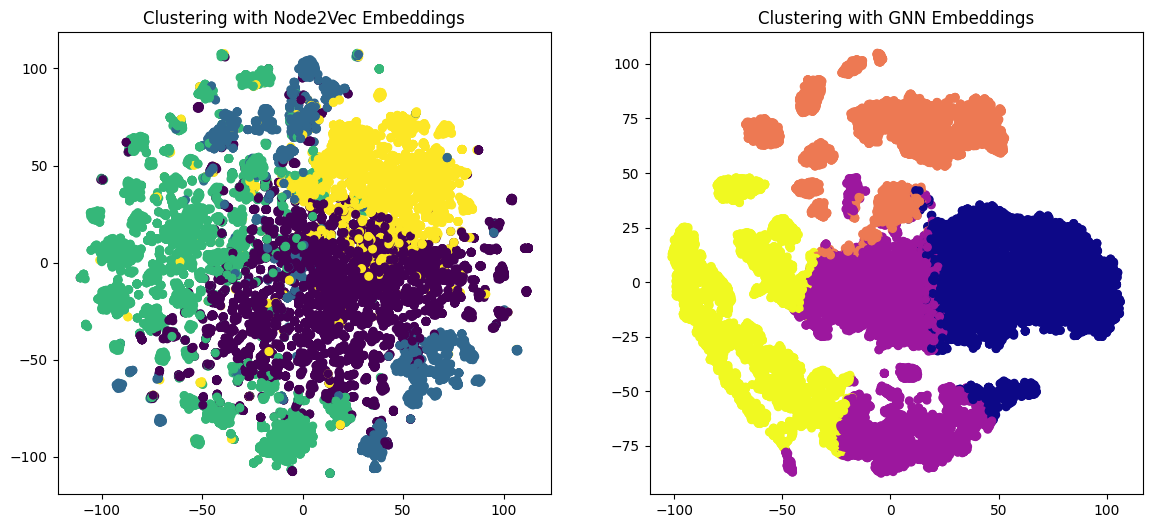

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_n2v = tsne.fit_transform(embeddingsN2v)
reduced_gcn = tsne.fit_transform(embeddingsGCN)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(reduced_n2v[:, 0], reduced_n2v[:, 1], c=labelsN2V, cmap='viridis', s=30)
axes[0].set_title("Clustering with Node2Vec Embeddings")

axes[1].scatter(reduced_gcn[:, 0], reduced_gcn[:, 1], c=labelsGSM, cmap='plasma', s=30)
axes[1].set_title("Clustering with GNN Embeddings")

plt.show()

### DBSCAN

#### Επιλογη παραμέτρων

Σύμφωνα με τον εμπειρικό κανόνα min_samples>dimensions+1.Για την δική μας περίπτωση θα επιλέξουμε 129.
Για να βρούμε την βέλτιστη τιμη της παραμέτρου eps θα ακολουθήσουμε τα εξής βήματα.

1:Υπολογισμός των αποστάσεων για τους k-nearest neighbors για k=min_samples-1.

2:Ταξινόμηση αυτών των αποστάσεων.

3:Δημιουργία γραφήματος αποστάσεων για να βρούμε το γόνατο (το σημείο όπου οι αποστάσεις αυξάνονται απότομα).

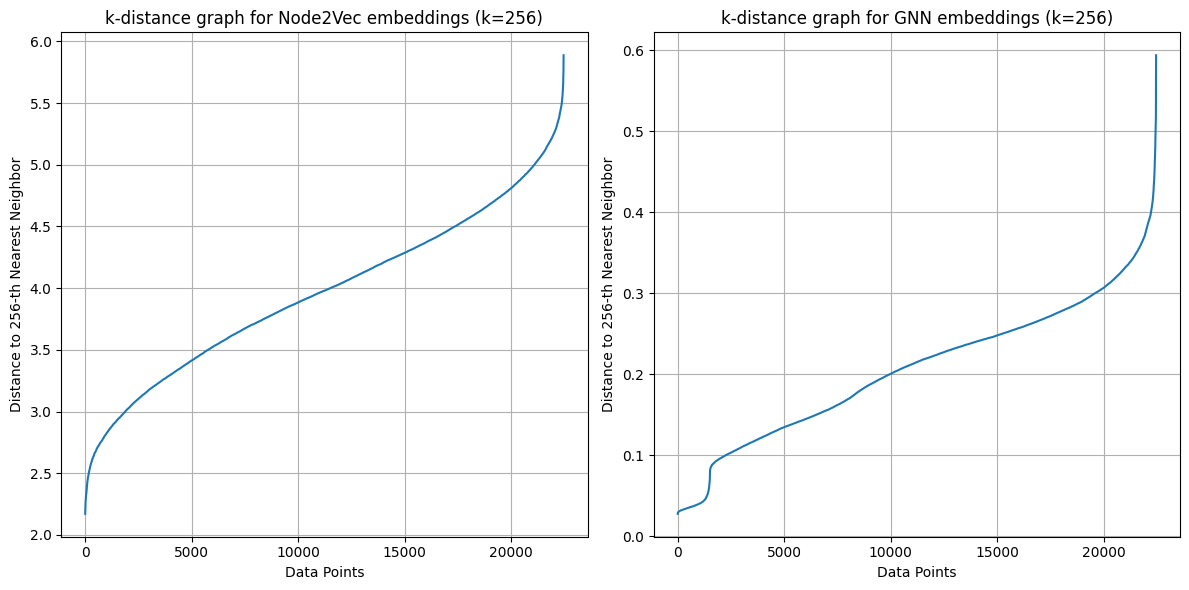

In [23]:
from sklearn.neighbors import NearestNeighbors
k = 256

X1 = embeddingsN2v  # Το reduced embedding για Node2Vec
neighbors_n2v = NearestNeighbors(n_neighbors=k)
neighbors_n2v.fit(X1)
distances_n2v, indices_n2v = neighbors_n2v.kneighbors(X1)
k_distances_n2v = distances_n2v[:, -1]
k_distances_n2v_sorted = np.sort(k_distances_n2v)

# Υπολογισμός για GCN embeddings
X2 = embeddingsGCN  # Το reduced embedding για GCN
neighbors_gcn = NearestNeighbors(n_neighbors=k)
neighbors_gcn.fit(X2)
distances_gcn, indices_gcn = neighbors_gcn.kneighbors(X2)
k_distances_gcn = distances_gcn[:, -1]
k_distances_gcn_sorted = np.sort(k_distances_gcn)

# Δημιουργία γραφημάτων k-distance στην ίδια σειρά
plt.figure(figsize=(12, 6))

# Node2Vec k-distance γραφήμα
plt.subplot(1, 2, 1)
plt.plot(k_distances_n2v_sorted)
plt.xlabel("Data Points")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title(f"k-distance graph for Node2Vec embeddings (k={k})")
plt.grid(True)

# GCN k-distance γραφήμα
plt.subplot(1, 2, 2)
plt.plot(k_distances_gcn_sorted)
plt.xlabel("Data Points")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title(f"k-distance graph for GΝN embeddings (k={k})")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Εφαρμογή

In [24]:
dbscan_n2v = DBSCAN(eps=3, min_samples=129)
labelsN2V_dbscan = dbscan_n2v.fit_predict(embeddingsN2v)


dbscan_gcn = DBSCAN(eps=0.3, min_samples=129)
labelsGSM_dbscan = dbscan_gcn.fit_predict(embeddingsGCN)

In [25]:
scores("Node2Vec (DBSCAN)", labels_encoded, labelsN2V_dbscan, embeddingsN2v)
scores("GΝN (DBSCAN)", labels_encoded, labelsGSM_dbscan, embeddingsGCN)

For Node2Vec (DBSCAN) method the metrics are:

Adjusted Rand Index (ARI): 0.0002
Normalized Mutual Information (NMI): 0.0001
Silhouette Score: -0.0094


For GΝN (DBSCAN) method the metrics are:

Adjusted Rand Index (ARI): 0.0005
Normalized Mutual Information (NMI): 0.0002
Silhouette Score: 0.0956




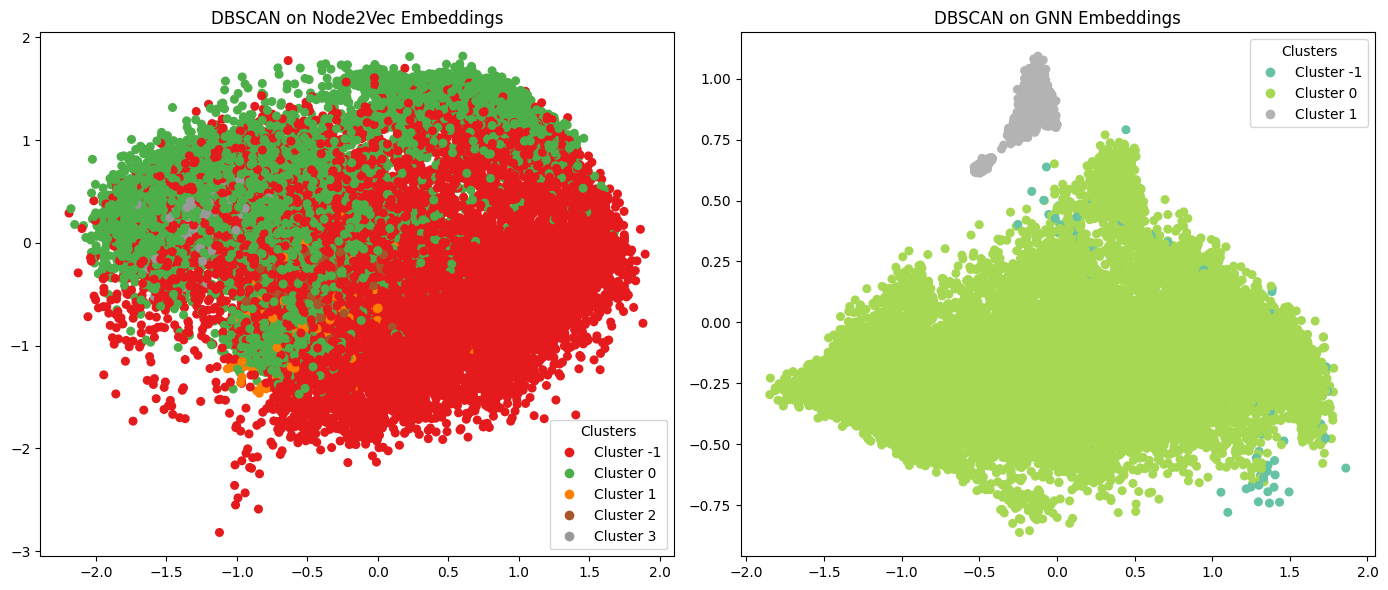

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=42)
reduced_n2v_db = pca.fit_transform(embeddingsN2v)
reduced_gcn_db = pca.fit_transform(embeddingsGCN)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# DBSCAN σε Node2Vec
scatter1 = axes[0].scatter(reduced_n2v_db[:, 0], reduced_n2v_db[:, 1],
                           c=labelsN2V_dbscan, cmap='Set1', s=30)
axes[0].set_title("DBSCAN on Node2Vec Embeddings")

# Δημιουργία legend
unique_labels_n2v = np.unique(labelsN2V_dbscan)
handles1 = [plt.Line2D([0], [0], marker='o', color='w',
                       label=f'Cluster {label}', markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8)
            for label in unique_labels_n2v]
axes[0].legend(handles=handles1, title="Clusters")

# DBSCAN σε GCN
scatter2 = axes[1].scatter(reduced_gcn_db[:, 0], reduced_gcn_db[:, 1],
                           c=labelsGSM_dbscan, cmap='Set2', s=30)
axes[1].set_title("DBSCAN on GΝN Embeddings")

# Δημιουργία legend
unique_labels_gcn = np.unique(labelsGSM_dbscan)
handles2 = [plt.Line2D([0], [0], marker='o', color='w',
                       label=f'Cluster {label}', markerfacecolor=scatter2.cmap(scatter2.norm(label)), markersize=8)
            for label in unique_labels_gcn]
axes[1].legend(handles=handles2, title="Clusters")

plt.tight_layout()
plt.show()


## Συμπεράσματα

Η μέθοδος Node2Vec παρουσιάζει σημαντικούς περιορισμούς, ειδικά όταν χρησιμοποιείται για κατηγοριοποίηση (clustering), όπως φαίνεται από τα παραπάνω αποτελέσματα. Το Node2Vec βασίζεται αποκλειστικά στη δομή του γράφου και αγνοεί τα χαρακτηριστικά των κόμβων, κάτι που μπορεί να είναι προβληματικό όταν οι κόμβοι που ανήκουν στην ίδια κατηγορία δεν είναι άμεσα συνδεδεμένοι ή όταν διαφορετικές κατηγορίες κόμβων βρίσκονται κοντά στο γράφο.


Αυτό αντικατοπτρίζεται ξεκάθαρα στις πολύ χαμηλές τιμές  Silhouette Score ή ακόμη και αρνητική (στην περίπτωση του DBSCAN), δείχνοντας την αδυναμία του να σχηματίσει διακριτές και συνεκτικές κοινότητες.

Αντίθετα, η χρήση GraphSAGE βελτίωσε σημαντικά την ποιότητα των embeddings.Το GraphSAGE εκπαιδεύεται να ενσωματώνει τόσο τη δομή του γράφου όσο και τα χαρακτηριστικά των κόμβων, μαθαίνοντας αναπαραστάσεις που είναι πιο αντιπροσωπευτικές.Αυτό οδήγησε σε αισθητά υψηλότερη Silhouette Score και πιο καθαρές, διακριτές συστάδες στα οπτικά αποτελέσματα. Η διαχωρισιμότητα μεταξύ των ομάδων είναι σαφώς καλύτερη.

Οι τιμές ARI και NMI παρέμειναν πολύ χαμηλά και για τις δύο μεθόδους υποδεικνύοντας ότι οι παραγόμενες ομάδες δεν σχετίζονται ουσιαστικά με τις πραγματικές κατηγορίες των κόμβων,γεγονός που ενδέχεται να σχετίζεται με τη φύση των δεδομένων ή με τη δυσκολία της ανάθεσης ετικετών.

Όσον αφορά τις μεθόδους clustering, παρατηρείται ότι Το KMeans πέτυχε καλύτερη απόδοση στο Silhouette Score σε σχέση με το DBSCAN και για τα δύο είδη embeddings.Το DBSCAN, αν και θεωρητικά ανθεκτικότερο στον θόρυβο και τις αραιές περιοχές του χώρου, απέτυχε να σχηματίσει συνεκτικές κοινότητες στα δεδομένα αυτά, ειδικά όταν τα embeddings ήταν αδύναμα όπως στην περίπτωση του Node2Vec.


Συμπερασματικά, η χρήση GraphSAGE σε συνδυασμό με KMeans προκύπτει ως η πλέον κατάλληλη στρατηγική για την ανίχνευση κοινοτήτων σε δεδομένα κοινωνικών δικτύων όπως αυτά του Facebook, προσφέροντας πιο αντιπροσωπευτικές αναπαραστάσεις και πιο διακριτές ομάδες.

## Ιδέα ανάπτυξης Πράκτορα Ενισχυτικής Μάθησης

Για να χτίσουμε τα θεμέλια του πράκτορα ενισχυτικής μάθησης (DQN agent) που θα εκτελεί την ομαδοποίηση κόμβων σε γράφο, είναι απαραίτητο να ορίσουμε με σαφήνεια τα βασικά συστατικά του περιβάλλοντος.Κάθε πρόβλημα ενισχυτικής μάθησης ορίζεται απο:

---States:H κατάσταση που βλέπει ο πράκτορας σε κάθε βήμα.Θα μπορούσαμε να χρησιμοποιήσουμε τα embeddings που εξήχθηκαν απο το Graph Sage


---Αctions: Οι διαθέσιμες ενέργειες είναι η ανάθεση ενός κόμβου σε ένα από τα τέσσερα προκαθορισμένα clusters. 


---Reward Function:Ως συνάρτηση ανταμοιβής θα μπορούσαμε να ορίσουμε την ευκλείδια αποσταση του embedding του κόμβου απο το κέντρο του cluster. 


---Transition: Μετά από κάθε ενέργεια, το περιβάλλον μεταβαίνει στον επόμενο κόμβο του γράφου, με προκαθορισμένη ή τυχαία σειρά


---Q-Network:Νευρωνικό Δίκτυο για την πρόβλεψη των Q-values.


---Replay Buffer:Αποθήκευση κάθε κατάστασης (state, action, reward, next_state) που επισκέπτεται ο agent, υποστηρίζοντας training σε batches.


---Exploration Strategy:Ο epsilon-greedy αλγόριθμος είναι μια ελκυστική επιλογη.


---Ολοκλήρωση ενός επεισοδίου:Είτε όταν έχουν ανατεθεί όλοι οι κόμβοι σε κάποια ομάδα είτε θέτοντας μέγιστο αριθμό βημάτων.

